In [1]:
import itertools
from math import exp
from typing import Type
import random
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

class SimulatedAnnealingSolver:
    """Uses the simulated-annealing algorithm with a given scheduling function to estimate a maximum for a function
    """

    def function_template(x: np.array) -> float:
        """For book-keeping, just make it known that the types of functions we are expecting to optimize take in numpy arrays and output scalars
        """
        return np.linalg.norm(x)
    
    def __init__(self, schedule_func: Type[function_template], tolerance=0.000001, step_scale = 0.01):
        """Given a certain time - as an integer - return a temperature float, which determines how likely we are to change positions.
        The schedule function gives a temperature at a given integer input time.
        The tolerance if how close we let the temperature reach 0 before deciding we are done.
        The step_scale decides how massive our random steps are as we attempt to maximize our function
        """
        self.schedule_func = schedule_func
        self.tolerance = tolerance
        self.step_scale = step_scale

    def maximize(self, function: type[function_template], x_min: np.array, x_max: np.array) -> tuple[np.array, float]:
        """Here is the actual algorithm to maximize a function 
        """
        current = (x_min + x_max) / 2
        t = 0
        while True:
            temperature = self.schedule_func(t)
            t += 1
            if temperature <= self.tolerance:
                return current, function(current)
            else:
                next = self.random_step(current)
                delta = function(next) - function(current)
                if delta > 0:
                    # If the random change in position resulted in a positive change, we will definitely take the step in that direction
                    current = next
                else:
                    # We only have a certain chance of taking it
                    prob = exp(delta / temperature)
                    if random.random() <= prob:
                        current = next
    
    def random_step(self, x: np.array) -> np.array:
        """Take a step away from the input in a random direction
        """
        change = np.random.rand(x.shape[0]) * self.step_scale
        return x + change
    
    def plot_max(self, function: Type[function_template], x_min: float, x_max: float, y_min: float, y_max: float, title: str):
        """Estimate the maximum achievable value of our function, and plot the result
        """
        dx = (x_max - x_min) / 100
        dy = (y_max - y_min) / 100
        X, Y = np.mgrid[x_min:x_max+dx:dx, y_min:y_max+dx:dy]
        Z = np.zeros(X.shape)
        for i, j in itertools.product(range(X.shape[0]), range(X.shape[1])):
            Z[i, j] = function(np.array([X[i,j], Y[i,j]]))

        # From https://matplotlib.org/stable/gallery/mplot3d/surface3d.html#sphx-glr-gallery-mplot3d-surface3d-py
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        
        # Plot the surface
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
        # Customize the z axis.
        ax.set_zlim(np.min(Z), np.max(Z))
        # Customize the z axis.
        # A StrMethodFormatter is used automatically
        ax.zaxis.set_major_formatter('{x:.02f}')

        # Add a color bar which maps values to colors.
        fig.colorbar(surf, shrink=0.5, aspect=5)
        
        # Estimate our maximum value via whatever algorithm we choose
        input_point, max_value = self.maximize(function, x_min=np.array([x_min,y_min]), x_max=np.array([x_max,y_max]))
        ax.scatter(input_point[0], input_point[1], max_value, c='r', marker='o')

        plt.title(title)
        plt.show()

        plt.close(fig)

In [2]:
def bump(x: np.array) -> float:
    """The Bump function. Very smooth, but note that the constraints on
    this function cannot be easily encoded into the chromosonal design
    of the GA.

    Range: x_i is in (0,100)

    :param numpy.array x: The (n x 1) input vector
    """
    n = len(x)
    cos_x = np.cos(x)
    term1 = np.sum(cos_x**4) - 2 * np.prod(cos_x**2)
    term2 = np.sqrt(np.sum(np.multiply(1.0 + np.arange(n), x**2)))
    return abs(term1 / term2)

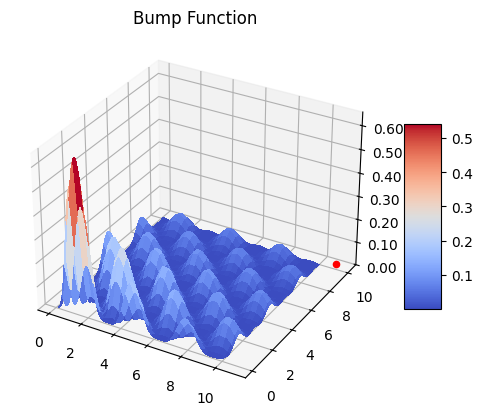

In [3]:
solver = SimulatedAnnealingSolver(lambda n : exp(-n/100))

solver.plot_max(function=bump, x_min=0.1, x_max=10, y_min=0.1, y_max=10, title="Bump Function")